In [5]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

In [38]:
@jax.jit
def akima_interp_coeffs(x, y):
    dx = x[1:] - x[:-1]
    mi = (y[1:] - y[:-1]) / dx

    # these values are imposed for points
    # at the ends
    s0 = mi[0:1]
    s1 = (mi[0:1] + mi[1:2]) / 2.0
    snm2 = (mi[-3:-2] + mi[-2:-1]) / 2.0
    snm1 = mi[-2:-1]

    wim1 = jnp.abs(mi[3:] - mi[2:-1]) 
    wi = jnp.abs(mi[1:-2] - mi[0:-3])
    denom = wim1 + wi
    numer = wim1 * mi[1:-2] + wi * mi[2:-1]

    smid = jnp.where(
        jnp.abs(denom) >= 1e-12,
        numer / denom,
        (mi[1:-2] + mi[2:-1]) / 2.0,
    )
    s = jnp.concatenate([s0, s1, smid, snm2, snm1])

    # these coeffs are for
    # P(x) = a + b * (x-xi) + c * (x-xi)**2 + d * (x-xi)**3
    # for a point x that falls in [xi, xip1]
    a = y[:-1]
    b = s[:-1]
    c = (3 * mi - 2 * s[:-1] - s[1:]) / dx
    d = (s[:-1] + s[1:] - 2 * mi) / dx / dx

    return (a, b, c, d)


@jax.jit
def akima_interp(x, xp, yp, coeffs=None):
    if coeffs is None:
        coeffs = akima_interp_coeffs(xp, yp)

    i = jnp.clip(jnp.searchsorted(xp, x, side='right'), 1, len(xp) - 1) - 1
    
    # these coeffs are for
    # P(x) = a + b * (x-xi) + c * (x-xi)**2 + d * (x-xi)**3
    # for a point x that falls in [xi, xip1]
    a, b, c, d = coeffs
    dx = x - xp[i]
    dx2 = dx * dx
    dx3 = dx2 * dx
    xval = a[i] + b[i] * dx + c[i] * dx2 + d[i] * dx3

    xval = jnp.where(x < xp[0], 0, xval)
    xval = jnp.where(x > xp[-1], 0, xval)
    return xval

In [39]:
xp = jnp.linspace(-4 * jnp.pi, 4 * jnp.pi, 1000)
yp = jnp.sin(xp)

print(jnp.allclose(yp, akima_interp(xp, xp, yp)), jnp.max(jnp.abs(yp - akima_interp(xp, xp, yp))))

True 4.939409e-10


In [40]:
x = jnp.linspace(-5 * jnp.pi, 5 * jnp.pi, 999)

y = akima_interp(x, xp, yp)

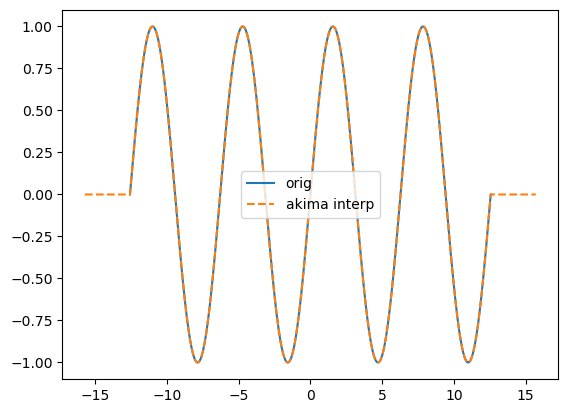

In [41]:
fig, axs = plt.subplots()

axs.plot(xp, yp, label="orig")
axs.plot(x, y, label="akima interp", linestyle="dashed")
axs.legend()